# Part 1: Gathering Data


In [2]:
from pathlib import Path
import time

import os
import requests
import pandas as pd

def fetch_and_cache(data_url, file, data_dir="data", force=False):
    """
    Download and cache a url and return the file object.

    data_url: the web address to download
    file: the file in which to save the results.
    data_dir: (default="data") the location to save the data
    force: if true the file is always re-downloaded

    return: The pathlib.Path object representing the file.
    """

    data_dir = Path(data_dir)
    data_dir.mkdir(exist_ok = True)
    file_path = data_dir / Path(file)
    # If the file already exists and we want to force a download then
    # delete the file first so that the creation date is correct.
    if force and file_path.exists():
        file_path.unlink()
    if force or not file_path.exists():
        print('Downloading...', end=' ')
        resp = requests.get(data_url)
        with file_path.open('wb') as f:
            f.write(resp.content)
        print('Done!')
        last_modified_time = time.ctime(file_path.stat().st_mtime)
    else:
        last_modified_time = time.ctime(file_path.stat().st_mtime)
        print("Using cached version that was downloaded (UTC):", last_modified_time)
    return file_path

def fetch_and_cache_gdrive(gdrive_id, file, data_dir="data", force=False):
    """
    Download and cache a url and return the file object.

    data_url: the web address to download
    file: the file in which to save the results.
    data_dir: (default="data") the location to save the data
    force: if true the file is always re-downloaded

    return: The pathlib.Path object representing the file.
    """

    data_dir = Path(data_dir)
    data_dir.mkdir(exist_ok = True)
    file_path = data_dir / Path(file)
    # If the file already exists and we want to force a download then
    # delete the file first so that the creation date is correct.
    if force and file_path.exists():
        file_path.unlink()
    if force or not file_path.exists():
        print('Downloading...', end=' ')
        download_file_from_google_drive(gdrive_id, file_path)
        print('Done!')
        last_modified_time = time.ctime(file_path.stat().st_mtime)
    else:
        last_modified_time = time.ctime(file_path.stat().st_mtime)
        print("Using cached version that was downloaded (UTC):", last_modified_time)
    return file_path



# https://stackoverflow.com/questions/38511444/python-download-files-from-google-drive-using-url

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)

    needs_confirm = needs_confirmation(response)

    if needs_confirm:
        params = { 'id' : id, 'confirm' : 't' ,}
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)

def needs_confirmation(response):

    return response.headers["Content-Type"] == 'text/html; charset=utf-8'

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)


In [113]:
# download required datasets

file_dict = {
    "aqs_sites.csv": "1fMfkw-NJ03VrQxYpDjM_4T6VDaWhvegi",
    "greenhouse_gas_emmitter_facilities.csv": "1yjTRv1OrsdWk-xNW4ZbFYB7_8Tt_x_fV",
    "greenhouse_gas_emmiter_gas_types.csv":"1akEokx_wqsgYqGNnNJsgebA6DDGHJLR2",
    "2020_daily_global_weather.csv":"15pjzsCiIE0uL69a4tZYgXoog8TKjIJNJ",
    "daily_wind_2020.csv": "18MqsjkN0EYPuLb0iR0U9sZYmNVCdd94h",
    "daily_temperature_2020.csv": "1Q62JlGtc65L2eU9FfQZcP9UyMCdcem1T",
    "traffic_volumes.csv": "1sZyjZSWz1xEoB26u_OrhKokZYhTIJRMD",
    "county_aqi_2020_daily.csv": "1uNH90XRceOfb16ctuUsYXVIEDeR2yaeC"
    }

for k, v in file_dict.items():
    path = f"./datasets/{k}"
    if not os.path.exists(path):
        download_file_from_google_drive(v,path)



## Creating Dataframes

In [3]:
aqs_site_df = pd.read_csv(f"./datasets/aqs_sites.csv")
gh_gas_facil_df = pd.read_csv(f"./datasets/greenhouse_gas_emmitter_facilities.csv")
gh_gas_type_df = pd.read_csv(f"./datasets/greenhouse_gas_emmiter_gas_types.csv")
weather_2020_df = pd.read_csv(f"./datasets/2020_daily_global_weather.csv")
wind_2020_df = pd.read_csv(f"./datasets/daily_wind_2020.csv")
temp_2020_df = pd.read_csv(f"./datasets/daily_temperature_2020.csv")
traffic_volumes_df = pd.read_csv(f"./datasets/traffic_volumes.csv", low_memory=False)
aqi_2020 = pd.read_csv(f"./datasets/county_aqi_2020_daily.csv")

/home/jamshedu/miniconda3/envs/msse-python/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


### aqs site data

In [4]:
print(aqs_site_df.columns)
display(aqs_site_df.sample(10))

Index(['State Code', 'County Code', 'Site Number', 'Latitude', 'Longitude',
       'Datum', 'Elevation', 'Land Use', 'Location Setting',
       'Site Established Date', 'Site Closed Date', 'Met Site State Code',
       'Met Site County Code', 'Met Site Site Number', 'Met Site Type',
       'Met Site Distance', 'Met Site Direction', 'GMT Offset',
       'Owning Agency', 'Local Site Name', 'Address', 'Zip Code', 'State Name',
       'County Name', 'City Name', 'CBSA Name', 'Tribe Name',
       'Extraction Date'],
      dtype='object')


,State Code,County Code,Site Number,Latitude,Longitude,Datum,Elevation,Land Use,Location Setting,Site Established Date,...,Owning Agency,Local Site Name,Address,Zip Code,State Name,County Name,City Name,CBSA Name,Tribe Name,Extraction Date
12931,37,81,11,36.113333,-79.703889,WGS84,229.0,RESIDENTIAL,RURAL,1979-01-01,...,North Carolina Dept Of Environmental Quality,NaN,"KEELY PARK, KEELY RD,",27301.0,North Carolina,Guilford,Greensboro,"Greensboro-High Point, NC",NaN,2021-05-18
4311,16,79,8,47.545977,-116.136588,WGS84,700.0,INDUSTRIAL,SUBURBAN,1974-01-01,...,Idaho Department Of Health And Welfare-Environ...,NaN,KELLOGG JR HI SCH 800 BUNKER AVE,83837.0,Idaho,Shoshone,Kellogg (Kellogg-Wardner),NaN,NaN,2021-05-18
20075,55,139,9,44.016928,-88.547614,WGS84,0.0,INDUSTRIAL,URBAN AND CENTER CITY,1992-01-23,...,"Wisconsin Dept Of Natural Resources, Air Monit...",TRAILER IN PARKING LOT AT 455 MARION RD,"455 MARION ROAD, TRAILER IN PARKING LOT",NaN,Wisconsin,Winnebago,Oshkosh,"Oshkosh-Neenah, WI",NaN,2021-05-18
3254,12,57,80,27.875862,-82.062356,WGS84,32.0,INDUSTRIAL,RURAL,1973-01-01,...,Florida Department of Environmental Protection...,NaN,RT 2 BOX 279 NICHOLS RD,33547.0,Florida,Hillsborough,Not in a City,"Tampa-St. Petersburg-Clearwater, FL",NaN,2021-05-18
6050,19,153,61,41.622767,-93.657997,WGS84,277.0,RESIDENTIAL,SUBURBAN,1980-01-01,...,Polk County Physical Planning,NaN,"2916 30TH ST. NW, EASTER SEAL",NaN,Iowa,Polk,Des Moines,"Des Moines-West Des Moines, IA",NaN,2021-05-18
11430,34,1,9000,39.465017,-74.448791,WGS84,5.0,FOREST,RURAL,1991-09-18,...,National Park Service,NaN,Brigantine NWR,8205.0,New Jersey,Atlantic,Not in a City,"Atlantic City-Hammonton, NJ",NaN,2021-05-18
16891,47,145,11,35.904797,-84.565214,WGS84,282.0,RESIDENTIAL,RURAL,1976-01-01,...,Tennessee Division Of Air Pollution Control,NaN,2.6 MI W OF KINGSTON STEAM PLANT,NaN,Tennessee,Roane,Not in a city,"Knoxville, TN",NaN,2021-05-18
15009,41,43,1003,44.398180,-122.721196,WGS84,155.0,COMMERCIAL,URBAN AND CENTER CITY,1985-01-01,...,Oregon Department Of Environmental Quality,NaN,1301 LONG STREET,NaN,Oregon,Linn,Sweet Home,"Albany, OR",NaN,2021-05-18
13331,38,55,101,47.404163,-101.140707,WGS84,640.0,INDUSTRIAL,RURAL,1980-04-01,...,North American Coal,NaN,FALKIRK #1,NaN,North Dakota,McLean,Not in a city,NaN,NaN,2021-05-18
17217,48,61,6,25.892518,-97.493830,WGS84,6.0,COMMERCIAL,URBAN AND CENTER CITY,1993-07-01,...,University of Texas Rio Grande Valley,Brownsville,344 Porter Drive,78520.0,Texas,Cameron,Brownsville,"Brownsville-Harlingen, TX",NaN,2021-05-18


### gh gas facility data

In [5]:
print(gh_gas_facil_df.columns)
display(gh_gas_facil_df.sample(10))

Index(['V_GHG_EMITTER_FACILITIES.ADDRESS1',
       'V_GHG_EMITTER_FACILITIES.ADDRESS2',
       'V_GHG_EMITTER_FACILITIES.CEMS_USED', 'V_GHG_EMITTER_FACILITIES.CITY',
       'V_GHG_EMITTER_FACILITIES.COUNTY',
       'V_GHG_EMITTER_FACILITIES.COUNTY_FIPS',
       'V_GHG_EMITTER_FACILITIES.FACILITY_ID',
       'V_GHG_EMITTER_FACILITIES.LATITUDE',
       'V_GHG_EMITTER_FACILITIES.LONGITUDE',
       'V_GHG_EMITTER_FACILITIES.PRIMARY_NAICS_CODE',
       'V_GHG_EMITTER_FACILITIES.STATE', 'V_GHG_EMITTER_FACILITIES.STATE_NAME',
       'V_GHG_EMITTER_FACILITIES.YEAR', 'V_GHG_EMITTER_FACILITIES.ZIP',
       'V_GHG_EMITTER_FACILITIES.FACILITY_NAME',
       'V_GHG_EMITTER_FACILITIES.SECONDARY_NAICS_CODE',
       'V_GHG_EMITTER_FACILITIES.ADDITIONAL_NAICS_CODES',
       'V_GHG_EMITTER_FACILITIES.COGENERATION_UNIT_EMISS_IND',
       'V_GHG_EMITTER_FACILITIES.EPA_VERIFIED',
       'V_GHG_EMITTER_FACILITIES.PARENT_COMPANY',
       'V_GHG_EMITTER_FACILITIES.PLANT_CODE_INDICATOR'],
      dtype='object')


,V_GHG_EMITTER_FACILITIES.ADDRESS1,V_GHG_EMITTER_FACILITIES.ADDRESS2,V_GHG_EMITTER_FACILITIES.CEMS_USED,V_GHG_EMITTER_FACILITIES.CITY,V_GHG_EMITTER_FACILITIES.COUNTY,V_GHG_EMITTER_FACILITIES.COUNTY_FIPS,V_GHG_EMITTER_FACILITIES.FACILITY_ID,V_GHG_EMITTER_FACILITIES.LATITUDE,V_GHG_EMITTER_FACILITIES.LONGITUDE,V_GHG_EMITTER_FACILITIES.PRIMARY_NAICS_CODE,...,V_GHG_EMITTER_FACILITIES.STATE_NAME,V_GHG_EMITTER_FACILITIES.YEAR,V_GHG_EMITTER_FACILITIES.ZIP,V_GHG_EMITTER_FACILITIES.FACILITY_NAME,V_GHG_EMITTER_FACILITIES.SECONDARY_NAICS_CODE,V_GHG_EMITTER_FACILITIES.ADDITIONAL_NAICS_CODES,V_GHG_EMITTER_FACILITIES.COGENERATION_UNIT_EMISS_IND,V_GHG_EMITTER_FACILITIES.EPA_VERIFIED,V_GHG_EMITTER_FACILITIES.PARENT_COMPANY,V_GHG_EMITTER_FACILITIES.PLANT_CODE_INDICATOR
43305,1231 POPE STREET,NaN,NaN,MEMPHIS,SHELBY COUNTY,47157.0,1005312.0,35.166770,-89.958930,325199.0,...,TENNESSEE,2011.0,38108.0,PMC BIOGENIX INC,NaN,325611 325613 311999,N,NaN,PMC GROUP (100%),NaN
32249,140 SAMSONDALE AVE,NaN,NaN,WEST HAVERSTRAW,Rockland,36087.0,1000780.0,41.204400,-73.968900,221112.0,...,NEW YORK,2010.0,10993.0,Bowline Generating Station,NaN,NaN,N,NaN,GENON ENERGY INC (100%),NaN
33398,2217 Oakland Road,NaN,NaN,Clinton,VAN BUREN COUNTY,5141.0,1007545.0,35.631540,-92.392770,211111.0,...,ARKANSAS,2015.0,72031.0,Hilltop Compressor Station,NaN,NaN,N,NaN,BHP BILLITON (100%),N
35383,1374 BRYAN GRIFFIN ROAD,NaN,NaN,BUTLER,PENDLETON COUNTY,21191.0,1005271.0,38.735550,-84.408180,562212.0,...,KENTUCKY,2019.0,41006.0,RUMPKE OF KENTUCKY INC,NaN,NaN,N,NaN,RUMPKE CONSOLIDATED COS INC (100%),N
71480,1010 Muldoon Avenue,NaN,NaN,Staten Island,RICHMOND COUNTY,36085.0,1002843.0,40.565216,-74.193377,562212.0,...,NEW YORK,2019.0,10312.0,Fresh Kills Landfill,NaN,NaN,N,NaN,CITY OF NEW YORK (100%),N
50787,45 Route 446,NaN,NaN,SMETHPORT,MCKEAN COUNTY,42083.0,1000193.0,41.859383,-78.445170,324199.0,...,PENNSYLVANIA,2019.0,16749.0,INTERNATIONAL WAXES INC,NaN,NaN,N,NaN,THE INTERNATIONAL GROUP INC (100%),N
54789,2210 S. Azusa Ave.,NaN,NaN,West Covina,LOS ANGELES COUNTY,6037.0,1011449.0,34.036441,-117.902294,562212.0,...,CALIFORNIA,2017.0,91792.0,BKK Corporation,NaN,NaN,N,NaN,BKK CORP (100%),N
14799,1111 Bagby St. Sky Lobby 2,NaN,NaN,Houston,HARRIS COUNTY,48201.0,1008396.0,29.758940,-95.370960,211111.0,...,TEXAS,2015.0,77002.0,EOG Resources Inc. 515 Powder River basin,NaN,NaN,N,NaN,EOG RESOURCES INC (100%),N
14355,103 FUNSTON ROAD,NaN,NaN,KANSAS CITY,WYANDOTTE COUNTY,20209.0,1005745.0,39.142019,-94.615315,327993.0,...,KANSAS,2015.0,66115.0,CERTAINTEED CORP.,NaN,NaN,N,NaN,SAINT-GOBAIN CORP (100%),N
57857,19801 NE 36TH ST,NaN,NaN,HARRAH,Oklahoma,40109.0,1000859.0,35.508900,-97.178900,221112.0,...,OKLAHOMA,2019.0,73045.0,Horseshoe Lake,NaN,NaN,N,NaN,OGE ENERGY CORP (100%),Y


### gh gas type data

In [6]:
print(gh_gas_type_df.columns)
display(gh_gas_type_df.sample(10))

Index(['V_GHG_EMITTER_GAS.ADDRESS1', 'V_GHG_EMITTER_GAS.ADDRESS2',
       'V_GHG_EMITTER_GAS.CITY', 'V_GHG_EMITTER_GAS.CO2E_EMISSION',
       'V_GHG_EMITTER_GAS.COUNTY', 'V_GHG_EMITTER_GAS.FACILITY_ID',
       'V_GHG_EMITTER_GAS.GAS_CODE', 'V_GHG_EMITTER_GAS.GAS_NAME',
       'V_GHG_EMITTER_GAS.LATITUDE', 'V_GHG_EMITTER_GAS.LONGITUDE',
       'V_GHG_EMITTER_GAS.STATE', 'V_GHG_EMITTER_GAS.STATE_NAME',
       'V_GHG_EMITTER_GAS.YEAR', 'V_GHG_EMITTER_GAS.ZIP',
       'V_GHG_EMITTER_GAS.FACILITY_NAME', 'V_GHG_EMITTER_GAS.COUNTY_FIPS'],
      dtype='object')


,V_GHG_EMITTER_GAS.ADDRESS1,V_GHG_EMITTER_GAS.ADDRESS2,V_GHG_EMITTER_GAS.CITY,V_GHG_EMITTER_GAS.CO2E_EMISSION,V_GHG_EMITTER_GAS.COUNTY,V_GHG_EMITTER_GAS.FACILITY_ID,V_GHG_EMITTER_GAS.GAS_CODE,V_GHG_EMITTER_GAS.GAS_NAME,V_GHG_EMITTER_GAS.LATITUDE,V_GHG_EMITTER_GAS.LONGITUDE,V_GHG_EMITTER_GAS.STATE,V_GHG_EMITTER_GAS.STATE_NAME,V_GHG_EMITTER_GAS.YEAR,V_GHG_EMITTER_GAS.ZIP,V_GHG_EMITTER_GAS.FACILITY_NAME,V_GHG_EMITTER_GAS.COUNTY_FIPS
66102,8901 WISCONSIN AVENUE,NaN,BETHESDA,16.092,MONTGOMERY COUNTY,1000756,N2O,Nitrous Oxide,39.000798,-77.094409,MD,MARYLAND,2012,20889,Naval Support Activity Bethesda,24031.0
80078,4000 TULIP TREE DR,NaN,PRINCETON,28.000,GIBSON COUNTY,1001828,CH4,Methane,38.292700,-87.564500,IN,INDIANA,2013,47670,TOYOTA MOTOR MFG IN INC,18051.0
105761,38-54 Vernon Blvd,NaN,Long Island City,35.250,Queens,1000567,CH4,Methane,40.760000,-73.750000,NY,NEW YORK,2012,11101,Ravenswood Steam Plant,36081.0
11653,6 MI SW OF,NaN,PORT FOURCHON,24896.300,LAFOURCHE,1003000,CO2,Carbon Dioxide,29.069510,-90.323700,LA,LOUISIANA,2011,70357,TIMBALIER BAY PRODUCTION COMPLEX,22057.0
86386,1905 KENTUCKY HIGHWAY 3249,NaN,STANFORD,5.200,LINCOLN,1003693,CO2,Carbon Dioxide,37.468889,-84.675556,KY,KENTUCKY,2011,40484,TRI-K LANDFILL INC,21137.0
189610,BUILDING 82 MOWRY ROAD,NaN,GAINESVILLE,90.592,Alachua,1000402,N2O,Nitrous Oxide,29.639700,-82.348600,FL,FLORIDA,2011,32611,University of Florida Cogeneration Plant,12001.0
146608,440 NORTH 9TH STREET,NaN,LAWRENCE,50501.000,DOUGLAS COUNTY,1003370,CO2,Carbon Dioxide,38.979930,-95.214430,KS,KANSAS,2015,66044,ICL,20045.0
211861,NaN,NaN,Offshore,11532.750,NaN,1011643,CH4,Methane,28.971577,-89.514681,LA,LOUISIANA,2018,0,WD 79 A & F (Complex ID # 20491),NaN
65910,1230 Independence Parkway S,NaN,La Porte,4582.200,HARRIS COUNTY,1004227,CO2,Carbon Dioxide,29.718368,-95.085830,TX,TEXAS,2013,77571,INEOS POLYPROPYLENE,48201.0
197885,6100 N. Western Avenue,NaN,Oklahoma City,10.430,Oklahoma,1008529,N2O,Nitrous Oxide,35.533760,-97.529760,OK,OKLAHOMA,2011,73118,Chesapeake Operating LLC 350 - South Oklahoma...,40109.0


### weather 2020 data 

In [7]:
print(weather_2020_df.columns)
display(weather_2020_df.sample(10))

Index(['Unnamed: 0', 'Station', 'Date', 'TAVG', 'Latitude', 'Longitude',
       'Elevation', 'PRCP'],
      dtype='object')


,Unnamed: 0,Station,Date,TAVG,Latitude,Longitude,Elevation,PRCP
424025,424025,CI000085406,2020-04-26,207.0,-18.3500,-70.3330,58.0,0.0
635668,635668,CA00401HP5R,2020-06-24,230.0,49.7000,-103.8000,589.0,117.0
240432,240432,CHM00054208,2020-03-06,-33.0,42.1830,116.4670,1247.0,0.0
255105,255105,CA007098603,2020-03-10,-102.0,48.0500,-77.7833,336.0,70.0
869673,869673,CA008402644,2020-08-28,123.0,49.6833,-56.0833,48.0,0.0
454683,454683,USS0008L02S,2020-05-04,75.0,38.4200,-108.3800,2865.1,0.0
848367,848367,IN009120400,2020-08-22,259.0,14.2830,74.4500,9.0,386.0
685236,685236,USS0019D03S,2020-07-07,90.0,45.1100,-119.5000,1569.7,0.0
910938,910938,USS0010J17S,2020-09-08,-25.0,40.8900,-110.8300,2675.2,76.0
882051,882051,SZE00116090,2020-08-31,147.0,46.8167,6.9500,490.0,107.0


### wind 2020 data

In [8]:
print(wind_2020_df.columns)
display(wind_2020_df.sample(10))

Index(['State Code', 'County Code', 'Site Num', 'Parameter Code', 'POC',
       'Latitude', 'Longitude', 'Datum', 'Parameter Name', 'Sample Duration',
       'Pollutant Standard', 'Date Local', 'Units of Measure', 'Event Type',
       'Observation Count', 'Observation Percent', 'Arithmetic Mean',
       '1st Max Value', '1st Max Hour', 'AQI', 'Method Code', 'Method Name',
       'Local Site Name', 'Address', 'State Name', 'County Name', 'City Name',
       'CBSA Name', 'Date of Last Change'],
      dtype='object')


,State Code,County Code,Site Num,Parameter Code,POC,Latitude,Longitude,Datum,Parameter Name,Sample Duration,...,AQI,Method Code,Method Name,Local Site Name,Address,State Name,County Name,City Name,CBSA Name,Date of Last Change
196576,18,89,34,61104,1,41.653501,-87.435561,NAD83,Wind Direction - Resultant,1 HOUR,...,NaN,68,Instrumental - RM Young Ultrasonic Anemometer ...,East Chicago-Marina,East Chicago- Marina/ 3301 Aldis St.,Indiana,Lake,East Chicago,"Chicago-Naperville-Elgin, IL-IN-WI",2021-02-25
240029,24,31,3001,61104,1,39.114313,-77.106876,WGS84,Wind Direction - Resultant,1 HOUR,...,NaN,24,INSTRUMENTAL - VECTOR SUMMATION LEVEL 4,Rockville,Lathrop E. Smith Environmental Education Cente...,Maryland,Montgomery,Not in a city,"Washington-Arlington-Alexandria, DC-VA-MD-WV",2021-01-15
445170,49,3,7001,61104,1,41.945874,-112.233973,WGS84,Wind Direction - Resultant,1 HOUR,...,NaN,20,INSTRUMENTAL - VECTOR SUMMATION,WASHAKIE,"8600 WEST 24000 NORTH PORTAGE, UTAH",Utah,Box Elder,Not in a city,"Ogden-Clearfield, UT",2021-02-09
223193,21,111,1041,61103,1,38.231580,-85.826780,WGS84,Wind Speed - Resultant,1 HOUR,...,NaN,129,Ultrasonic Wind Sensor MD1425A - Vector Averag...,Algonquin Parkway,4201 ALGONQUIN PKWY,Kentucky,Jefferson,Louisville,"Louisville/Jefferson County, KY-IN",2021-04-21
259517,26,125,12,61104,1,42.679172,-83.130141,WGS84,Wind Direction - Resultant,1 HOUR,...,NaN,20,INSTRUMENTAL - VECTOR SUMMATION,Rochester Hills,"ROCHESTER FIRE STATION, 277 E 2ND STREET",Michigan,Oakland,Rochester,"Detroit-Warren-Dearborn, MI",2021-03-01
266478,26,163,26,61103,1,42.359175,-83.255146,WGS84,Wind Speed - Resultant,1 HOUR,...,NaN,20,INSTRUMENTAL - VECTOR SUMMATION,NORTH OF JOY RD./WEST OF SPINOZA/NEAR DETROIT ...,22000 JOY ROAD (DET-JOY RD),Michigan,Wayne,Detroit,"Detroit-Warren-Dearborn, MI",2021-03-01
144958,8,67,1004,61103,1,37.303890,-107.484167,WGS84,Wind Speed - Resultant,1 HOUR,...,NaN,20,INSTRUMENTAL - VECTOR SUMMATION,NaN,Weminuche Wilderness Area - Shamrock Station,Colorado,La Plata,Not in a city,"Durango, CO",2021-03-01
129534,6,111,7,61104,1,34.210169,-118.870509,NAD83,Wind Direction - Resultant,1 HOUR,...,NaN,20,INSTRUMENTAL - VECTOR SUMMATION,Thousand Oaks,"2323 Moorpark Road, Thousand Oaks, CA 91360",California,Ventura,Thousand Oaks,"Oxnard-Thousand Oaks-Ventura, CA",2021-02-12
76243,6,43,3,61104,1,37.713250,-119.706200,WGS84,Wind Direction - Resultant,1 HOUR,...,NaN,20,INSTRUMENTAL - VECTOR SUMMATION,Yosemite NP - Turtleback Dome,"TURTLEBACK DOME, YOSEMITE NATL' PK 95389",California,Mariposa,Not in a city,NaN,2021-02-16
42268,6,19,4001,61103,1,36.597442,-119.503659,NAD83,Wind Speed - Resultant,1 HOUR,...,NaN,20,INSTRUMENTAL - VECTOR SUMMATION,Parlier,"9240 S. RIVERBEND, PARLIER 93648",California,Fresno,Parlier,"Fresno, CA",2021-04-28


### temp 2020 data

In [9]:
print(temp_2020_df.columns)
display(temp_2020_df.sample(10))

Index(['State Code', 'County Code', 'Site Num', 'Parameter Code', 'POC',
       'Latitude', 'Longitude', 'Datum', 'Parameter Name', 'Sample Duration',
       'Pollutant Standard', 'Date Local', 'Units of Measure', 'Event Type',
       'Observation Count', 'Observation Percent', 'Arithmetic Mean',
       '1st Max Value', '1st Max Hour', 'AQI', 'Method Code', 'Method Name',
       'Local Site Name', 'Address', 'State Name', 'County Name', 'City Name',
       'CBSA Name', 'Date of Last Change'],
      dtype='object')


,State Code,County Code,Site Num,Parameter Code,POC,Latitude,Longitude,Datum,Parameter Name,Sample Duration,...,AQI,Method Code,Method Name,Local Site Name,Address,State Name,County Name,City Name,CBSA Name,Date of Last Change
217323,48,233,1073,62101,1,35.676200,-101.440100,NAD83,Outdoor Temperature,1 HOUR,...,NaN,40,INSTRUMENTAL - ELECTRONIC OR MACHINE AVG.,Borger FM 1559,19440 FM 1559,Texas,Hutchinson,Borger,"Borger, TX",2021-03-19
258835,56,1,802,62101,1,41.269167,-105.614722,WGS84,Outdoor Temperature,1 HOUR,...,NaN,41,INSTRUMENTAL - ELEC. OR MACH. AVG. LEVEL 1,WEST MET SITE,"WEST MET SITE, Mountain Cement, Laramie",Wyoming,Albany,Not in a city,"Laramie, WY",2021-03-08
161716,35,45,9,62101,2,36.742227,-107.977567,WGS84,Outdoor Temperature,1 HOUR,...,NaN,42,INSTRUMENTAL - ELEC. OR MACH. AVG. LEVEL 2,1ZB Bloomfield,"2200 N 1st Street, Bloomfield, NM",New Mexico,San Juan,Bloomfield,"Farmington, NM",2021-02-04
163581,35,45,1005,62101,2,36.796667,-108.473138,WGS84,Outdoor Temperature,1 HOUR,...,NaN,42,INSTRUMENTAL - ELEC. OR MACH. AVG. LEVEL 2,1H Substation,"Shiprock Electrical Substation, Waterflow, NM",New Mexico,San Juan,Not in a city,"Farmington, NM",2021-02-04
205552,48,141,55,62101,1,31.746775,-106.402806,WGS84,Outdoor Temperature,1 HOUR,...,NaN,40,INSTRUMENTAL - ELECTRONIC OR MACHINE AVG.,Ascarate Park SE,650 R E Thomason Loop,Texas,El Paso,El Paso,"El Paso, TX",2021-03-19
276996,56,35,100,62101,1,42.790700,-110.055100,WGS84,Outdoor Temperature,1 HOUR,...,NaN,41,INSTRUMENTAL - ELEC. OR MACH. AVG. LEVEL 1,Daniel South,DANIEL SOUTH ~ 4 MILES SO OF DANIEL WYO OFF OF...,Wyoming,Sublette,Not in a city,NaN,2021-03-03
118037,25,25,42,62101,1,42.329500,-71.082600,WGS84,Outdoor Temperature,1 HOUR,...,NaN,40,INSTRUMENTAL - ELECTRONIC OR MACHINE AVG.,DUDLEY SQUARE ROXBURY,HARRISON AVE,Massachusetts,Suffolk,Boston,"Boston-Cambridge-Newton, MA-NH",2021-03-25
87910,16,59,4,62101,1,45.181897,-113.890285,WGS84,Outdoor Temperature,1 HOUR,...,NaN,60,Instrumental - Vaisala 435C RH/AT Sensor,Salmon - Charles St.,618 North Saint Charles Street,Idaho,Lemhi,Not in a city,NaN,2021-03-31
99623,19,163,15,62101,1,41.530011,-90.587611,WGS84,Outdoor Temperature,1 HOUR,...,NaN,40,INSTRUMENTAL - ELECTRONIC OR MACHINE AVG.,"DAVENPORT, JEFFERSON SCH.",10TH ST. & VINE ST. DAVENPORT,Iowa,Scott,Davenport,"Davenport-Moline-Rock Island, IA-IL",2021-01-12
175859,40,47,555,62101,1,36.512363,-97.845959,NAD83,Outdoor Temperature,1 HOUR,...,NaN,60,Instrumental - Vaisala 435C RH/AT Sensor,NaN,"11826 N 30th St, Kremlin, OK 73753",Oklahoma,Garfield,Enid,"Enid, OK",2021-02-10


### traffic volumes data

In [10]:
print(traffic_volumes_df.columns)
display(traffic_volumes_df.sample(10))

Index(['OBJECTID_1', 'OBJECTID', 'District', 'Route', 'Rte_SFX', 'County',
       'PM_PFX', 'Postmile', 'PM_SFX', 'Descriptn', 'Back_pk_h', 'Back_pk_m',
       'Back_AADT', 'Ahead_pk_h', 'Ahead_pk_m', 'Ahead_AADT', 'Lon_S_or_W',
       'Lat_S_or_W', 'Lon_N_or_E', 'Lat_N_or_E'],
      dtype='object')


,OBJECTID_1,OBJECTID,District,Route,Rte_SFX,County,PM_PFX,Postmile,PM_SFX,Descriptn,Back_pk_h,Back_pk_m,Back_AADT,Ahead_pk_h,Ahead_pk_m,Ahead_AADT,Lon_S_or_W,Lat_S_or_W,Lon_N_or_E,Lat_N_or_E
4065,4066,4066,7,5,,LA,,29.160,,"BURBANK, OLIVE AVENUE",15000,239000,224000,14500,231000,215000,-118.3110085,34.17873575,-118.3109035,34.17886594
971,972,972,3,32,,BUT,,15.211,,"CHICO, HUMBOLT ROAD",720,7100,5700,430,4500,3800,-121.7366167,39.76246931,-121.7366167,39.76246931
884,885,885,3,20,,SUT,,16.838,,"YUBA CITY, SUTTER STREET",5100,50000,47500,4450,50000,48200,-121.6122085,39.14260755,-121.6121875,39.14245663
1762,1763,1763,4,29,,SOL,,0.000,,"VALLEJO, JCT. RTE. 80",,,,1600,11000,9700,-122.2320721,38.07591487,-122.2320276,38.07648984
7056,7057,7057,12,91,,ORA,R,17.950,R,COAL CANYON ROAD RIGHT,9100,145000,139500,9100,145000,139500,Left Skipped - Input PM on Right Ind. Alignment,Left Skipped - Input PM on Right Ind. Alignment,-117.6872347,33.87186882
4898,4899,4899,8,10,,SBD,,33.291,,"REDLANDS, REDLANDS BOULEVARD",10200,147000,141000,11100,160000,153000,-117.1538342,34.03969472,-117.1540122,34.03944549
2519,2520,2520,4,580,,ALA,R,1.622,L,BEGIN LEFT ALIGN,,,,6800,83000,72700,-121.5879994,37.73991124,Right Skipped - Input PM on Left Ind. Alignment,Right Skipped - Input PM on Left Ind. Alignment
6159,6160,6160,10,165,,MER,,33.616,,"FIRST ST, HILMAR",1600,21100,10800,1500,24700,11800,-120.8501266,37.40789324,-120.8500313,37.40788624
5579,5580,5580,9,203,,MNO,,6.866,,MERIDIAN BLVD,1050,11000,8200,1050,10700,7400,-118.9460037,37.64376601,-118.946289,37.643352
64,65,65,1,29,,LAK,R,36.289,,RENFRO DRIVE,1200,12000,11500,1300,14100,13500,-122.857047,38.98399113,-122.8568738,38.98408767


### aqi data 2020

In [11]:
print(aqi_2020.columns)
display(aqi_2020.sample(10))

Index(['State Name', 'county Name', 'State Code', 'County Code', 'Date', 'AQI',
       'Category', 'Defining Parameter', 'Defining Site',
       'Number of Sites Reporting'],
      dtype='object')


,State Name,county Name,State Code,County Code,Date,AQI,Category,Defining Parameter,Defining Site,Number of Sites Reporting
29921,California,Solano,6,95,2020-11-01,79,Moderate,PM2.5,06-095-0004,3
172010,Nevada,Nye,32,23,2020-10-17,30,Good,PM10,32-023-0015,4
149661,Minnesota,Scott,27,139,2020-12-25,27,Good,Ozone,27-139-0505,1
297677,Vermont,Rutland,50,21,2020-09-14,26,Good,Ozone,50-021-0002,1
336642,Wyoming,Weston,56,45,2020-11-03,36,Good,Ozone,56-045-0003,2
98021,Iowa,Bremer,19,17,2020-04-17,42,Good,Ozone,19-017-0011,1
96501,Indiana,Vigo,18,167,2020-11-20,50,Good,PM2.5,18-167-0018,2
291908,Utah,Box Elder,49,3,2020-12-25,31,Good,Ozone,49-003-7001,1
108171,Kentucky,Daviess,21,59,2020-10-01,31,Good,Ozone,21-059-0005,1
165948,Montana,Sanders,30,89,2020-03-31,16,Good,PM2.5,30-089-0007,2


In [12]:
## dict to use to convert fro county abbreviation to county

county_abbreviations = {
"ALA" : "Alameda",
"ALP" : "Alpine",
"AMA" : "Amador",
"BUT" : "Butte",
"CC" : "Contra Costa",
"CLV" : "Calaveras",
"COL" : "Colusa",
"DN" : "Del Norte",
"ED" : "El Dorado",
"FRE" : "Fresno",
"GLE" : "Glenn",
"HUM" : "Humboldt",
"IMP" : "Imperial",
"INY" : "Inyo",
"KER" : "Kern",
"KIN" : "Kings",
"LA" : "Los Angeles",
"LAK" : "Lake",
"LAS" : "Lassen",
"MAD" : "Madera",
"MEN" : "Mendocino",
"MER" : "Merced",
"MNO" : "Mono",
"MOD" : "Modoc",
"MRN" : "Marin",
"MPA" : "Mariposa",
"MON" : "Monterey",
"NAP" : "Napa",
"NEV" : "Nevada	",
"ORA" : "Orange",
"PLA" : "Placer",
"PLU" : "Plumas",
"RIV" : "Riverside",
"SAC" : "Sacramento",
"SB" : "Santa Barbara",
"SBD" : "San Bernardino",
"SBT" : "San Benito",
"SCL" : "Santa Clara",
"SCR" : "Santa Cruz",
"SD" : "San Diego",
"SF" : "San Francisco",
"SHA" : "Shasta",
"SIE" : "Sierra",
"SIS" : "Siskiyou",
"SJ" : "San Joaquin",
"SLO" : "San Luis Obispo",
"SM" : "San Mateo",
"SOL" : "Solano",
"SON" : "Sonoma",
"STA" : "Stanislaus",
"SUT" : "Sutter",
"TEH" : "Tehama",
"TRI" : "Trinity",
"TUL" : "Tulare",
"TUO" : "Tuolumne",
"VEN" : "Ventura",
"YOL" : "Yolo",
"YUB" : "Yuba",
}

## Data wrangling

### decisions log
- we are going to only use data for the state of california because we are interested in using vehicle emissions data which we have for the state of california in addition to the factory emissions data 

In [13]:
daily_global_weather_2020 = pd.read_csv("datasets/2020_daily_global_weather.csv").drop(columns="Unnamed: 0")

us_greenhouse_gas_emission_direct_emitter_gas_type = pd.read_csv("datasets/greenhouse_gas_emmiter_gas_types.csv", low_memory=False)

aqi_sites = pd.read_csv("datasets/aqs_sites.csv")

daily_county_aqi = pd.read_csv("datasets/county_aqi_2020_daily.csv") 

daily_temp = pd.read_csv("datasets/daily_temperature_2020.csv")

daily_wind = pd.read_csv("datasets/daily_wind_2020.csv")

traffic_volumes = pd.read_csv("datasets/traffic_volumes.csv")

In [14]:
#PRCP is average percipitation in tenths of a mm, TAVG is tempearture average at each station for each day
daily_global_weather_2020

,Station,Date,TAVG,Latitude,Longitude,Elevation,PRCP
0,AE000041196,2020-01-01,211.0,25.3330,55.5170,34.0,0.0
1,AEM00041194,2020-01-01,217.0,25.2550,55.3640,10.4,0.0
2,AFM00040938,2020-01-01,54.0,34.2100,62.2280,977.2,23.0
3,AG000060611,2020-01-01,71.0,28.0500,9.6331,561.0,10.0
4,AGE00147708,2020-01-01,99.0,36.7200,4.0500,222.0,0.0
...,...,...,...,...,...,...,...
1064278,USW00094847,2020-10-22,96.0,42.2314,-83.3308,192.3,157.0
1064279,USW00094849,2020-10-22,67.0,45.0717,-83.5644,208.5,99.0
1064280,USW00094860,2020-10-22,77.0,42.8939,-85.5447,237.1,165.0
1064281,USW00094908,2020-10-22,73.0,42.3978,-90.7036,321.9,361.0


In [15]:
us_greenhouse_gas_emission_direct_emitter_gas_type.columns

Index(['V_GHG_EMITTER_GAS.ADDRESS1', 'V_GHG_EMITTER_GAS.ADDRESS2',
       'V_GHG_EMITTER_GAS.CITY', 'V_GHG_EMITTER_GAS.CO2E_EMISSION',
       'V_GHG_EMITTER_GAS.COUNTY', 'V_GHG_EMITTER_GAS.FACILITY_ID',
       'V_GHG_EMITTER_GAS.GAS_CODE', 'V_GHG_EMITTER_GAS.GAS_NAME',
       'V_GHG_EMITTER_GAS.LATITUDE', 'V_GHG_EMITTER_GAS.LONGITUDE',
       'V_GHG_EMITTER_GAS.STATE', 'V_GHG_EMITTER_GAS.STATE_NAME',
       'V_GHG_EMITTER_GAS.YEAR', 'V_GHG_EMITTER_GAS.ZIP',
       'V_GHG_EMITTER_GAS.FACILITY_NAME', 'V_GHG_EMITTER_GAS.COUNTY_FIPS'],
      dtype='object')

In [16]:
daily_county_aqi.columns

Index(['State Name', 'county Name', 'State Code', 'County Code', 'Date', 'AQI',
       'Category', 'Defining Parameter', 'Defining Site',
       'Number of Sites Reporting'],
      dtype='object')

In [17]:
aqi_sites.columns

Index(['State Code', 'County Code', 'Site Number', 'Latitude', 'Longitude',
       'Datum', 'Elevation', 'Land Use', 'Location Setting',
       'Site Established Date', 'Site Closed Date', 'Met Site State Code',
       'Met Site County Code', 'Met Site Site Number', 'Met Site Type',
       'Met Site Distance', 'Met Site Direction', 'GMT Offset',
       'Owning Agency', 'Local Site Name', 'Address', 'Zip Code', 'State Name',
       'County Name', 'City Name', 'CBSA Name', 'Tribe Name',
       'Extraction Date'],
      dtype='object')

#### The defining site column in daily_county_aqi is defined by "State Code"-"County Code"-"Site Number" for a given State and County in aqi_sites. Thus, the City name can be determined by the defining site using the aqi_sites table, if increased granularity is required.

In [18]:
daily_wind.columns

Index(['State Code', 'County Code', 'Site Num', 'Parameter Code', 'POC',
       'Latitude', 'Longitude', 'Datum', 'Parameter Name', 'Sample Duration',
       'Pollutant Standard', 'Date Local', 'Units of Measure', 'Event Type',
       'Observation Count', 'Observation Percent', 'Arithmetic Mean',
       '1st Max Value', '1st Max Hour', 'AQI', 'Method Code', 'Method Name',
       'Local Site Name', 'Address', 'State Name', 'County Name', 'City Name',
       'CBSA Name', 'Date of Last Change'],
      dtype='object')

## Aggregating Daily temp, wind speed and wind direction by state and county

## Data Cleaning/Prep on Daily Temperature Data

In [19]:
# Data Prep on daily temperature, wind speed and wind direction

# Extracting relevant columns
truncated_daily_temp = daily_temp[["State Code", "County Code", "Site Num", "State Name", "County Name", "City Name", "Latitude", "Longitude", "Date Local", "Arithmetic Mean"]]

# Array of US States and territories
US_States_territories = us_greenhouse_gas_emission_direct_emitter_gas_type["V_GHG_EMITTER_GAS.STATE_NAME"].unique()

# Only US States and territories should be in our data
truncated_daily_temp = truncated_daily_temp[truncated_daily_temp["State Name"].str.upper().isin(US_States_territories)]

# Impute missing 0s, with mean of the arithmetic mean, there are no null values
truncated_daily_temp["Arithmetic Mean"] = truncated_daily_temp["Arithmetic Mean"].replace(0, truncated_daily_temp["Arithmetic Mean"].mean())

# Rename Arithmetic Mean column to include temperature and units (Temp - F)
truncated_daily_temp = truncated_daily_temp.rename(columns={"Arithmetic Mean": "Mean Temperature (F)"})

In [20]:
truncated_daily_temp

,State Code,County Code,Site Num,State Name,County Name,City Name,Latitude,Longitude,Date Local,Mean Temperature (F)
0,1,53,1000,Alabama,Escambia,Not in a city,31.09210,-87.54350,2020-01-01,53.540000
1,1,53,1000,Alabama,Escambia,Not in a city,31.09210,-87.54350,2020-01-02,67.342857
2,1,53,1000,Alabama,Escambia,Not in a city,31.09210,-87.54350,2020-01-03,26.580000
3,1,53,1000,Alabama,Escambia,Not in a city,31.09210,-87.54350,2020-01-04,44.830000
4,1,53,1000,Alabama,Escambia,Not in a city,31.09210,-87.54350,2020-01-05,51.550000
...,...,...,...,...,...,...,...,...,...,...
290326,56,45,800,Wyoming,Weston,Newcastle,43.84539,-104.20512,2020-12-27,31.000000
290327,56,45,800,Wyoming,Weston,Newcastle,43.84539,-104.20512,2020-12-28,26.000000
290328,56,45,800,Wyoming,Weston,Newcastle,43.84539,-104.20512,2020-12-29,22.958333
290329,56,45,800,Wyoming,Weston,Newcastle,43.84539,-104.20512,2020-12-30,14.583333


## Data Prep on Daily Wind Data

In [21]:
# Extract relevant Columns
truncated_daily_wind = daily_wind[["State Code", "County Code", "Site Num", "State Name", "County Name", "City Name", "Latitude", "Longitude", "Parameter Name", "Date Local", "Arithmetic Mean"]]

# Only US States and territories should be in our data
truncated_daily_wind = truncated_daily_wind[truncated_daily_wind["State Name"].str.upper().isin(US_States_territories)]

# Seperate wind direction and wind speed before imputing missing values
daily_wind_speed = truncated_daily_wind[truncated_daily_wind["Parameter Name"] == "Wind Speed - Resultant"].reset_index(drop=True)

daily_wind_direction = truncated_daily_wind[truncated_daily_wind["Parameter Name"] == "Wind Direction - Resultant"].reset_index(drop=True)

# Impute missing values or 0 values with mean of the column
daily_wind_speed["Arithmetic Mean"] = daily_wind_speed["Arithmetic Mean"].replace(0, daily_wind_speed["Arithmetic Mean"].mean())

daily_wind_direction["Arithmetic Mean"] = daily_wind_direction["Arithmetic Mean"].replace(0, daily_wind_direction["Arithmetic Mean"].mean())

# Rename Arithmetic Mean columns to include the measurement and units
daily_wind_speed = daily_wind_speed.rename(columns={"Arithmetic Mean": "Mean Wind Speed (knots)"}).drop(columns=["Parameter Name"])
daily_wind_direction = daily_wind_direction.rename(columns={"Arithmetic Mean": "Mean Wind Direction (compass degrees)"}).drop(columns=["Parameter Name"])

In [22]:
daily_wind_speed

,State Code,County Code,Site Num,State Name,County Name,City Name,Latitude,Longitude,Date Local,Mean Wind Speed (knots)
0,1,53,1000,Alabama,Escambia,Not in a city,31.092100,-87.543500,2020-01-01,4.349492
1,1,53,1000,Alabama,Escambia,Not in a city,31.092100,-87.543500,2020-01-02,4.349492
2,1,53,1000,Alabama,Escambia,Not in a city,31.092100,-87.543500,2020-01-03,4.349492
3,1,53,1000,Alabama,Escambia,Not in a city,31.092100,-87.543500,2020-01-04,4.349492
4,1,53,1000,Alabama,Escambia,Not in a city,31.092100,-87.543500,2020-01-05,4.349492
...,...,...,...,...,...,...,...,...,...,...
239426,56,39,1013,Wyoming,Teton,Not in a city,44.373056,-110.830833,2020-12-27,1.795833
239427,56,39,1013,Wyoming,Teton,Not in a city,44.373056,-110.830833,2020-12-28,1.212500
239428,56,39,1013,Wyoming,Teton,Not in a city,44.373056,-110.830833,2020-12-29,1.441667
239429,56,39,1013,Wyoming,Teton,Not in a city,44.373056,-110.830833,2020-12-30,1.466667


In [23]:
daily_wind_direction

,State Code,County Code,Site Num,State Name,County Name,City Name,Latitude,Longitude,Date Local,Mean Wind Direction (compass degrees)
0,1,53,1000,Alabama,Escambia,Not in a city,31.092100,-87.543500,2020-01-01,179.900000
1,1,53,1000,Alabama,Escambia,Not in a city,31.092100,-87.543500,2020-01-02,108.857143
2,1,53,1000,Alabama,Escambia,Not in a city,31.092100,-87.543500,2020-01-03,271.000000
3,1,53,1000,Alabama,Escambia,Not in a city,31.092100,-87.543500,2020-01-04,230.100000
4,1,53,1000,Alabama,Escambia,Not in a city,31.092100,-87.543500,2020-01-05,251.100000
...,...,...,...,...,...,...,...,...,...,...
242333,56,39,1013,Wyoming,Teton,Not in a city,44.373056,-110.830833,2020-12-27,190.375000
242334,56,39,1013,Wyoming,Teton,Not in a city,44.373056,-110.830833,2020-12-28,171.375000
242335,56,39,1013,Wyoming,Teton,Not in a city,44.373056,-110.830833,2020-12-29,181.166667
242336,56,39,1013,Wyoming,Teton,Not in a city,44.373056,-110.830833,2020-12-30,173.666667


## Merging the wind, and temperature data

In [24]:
wind_data_merge = pd.merge(daily_wind_direction, daily_wind_speed, how='inner', on=["State Code", "County Code", "Site Num", "State Name", "County Name", "City Name", "Latitude", "Longitude", "Date Local"])

In [25]:
weather_data = truncated_daily_temp.merge(wind_data_merge, how='inner', on=["State Code", "County Code", "Site Num", "State Name", "County Name", "City Name", "Latitude", "Longitude", "Date Local"])

## Final dataset which includes weather data

In [26]:
weather_data

,State Code,County Code,Site Num,State Name,County Name,City Name,Latitude,Longitude,Date Local,Mean Temperature (F),Mean Wind Direction (compass degrees),Mean Wind Speed (knots)
0,1,53,1000,Alabama,Escambia,Not in a city,31.092100,-87.543500,2020-01-01,53.540000,179.900000,4.349492
1,1,53,1000,Alabama,Escambia,Not in a city,31.092100,-87.543500,2020-01-02,67.342857,108.857143,4.349492
2,1,53,1000,Alabama,Escambia,Not in a city,31.092100,-87.543500,2020-01-03,26.580000,271.000000,4.349492
3,1,53,1000,Alabama,Escambia,Not in a city,31.092100,-87.543500,2020-01-04,44.830000,230.100000,4.349492
4,1,53,1000,Alabama,Escambia,Not in a city,31.092100,-87.543500,2020-01-05,51.550000,251.100000,4.349492
...,...,...,...,...,...,...,...,...,...,...,...,...
228161,56,39,1013,Wyoming,Teton,Not in a city,44.373056,-110.830833,2020-12-27,15.250000,190.375000,1.795833
228162,56,39,1013,Wyoming,Teton,Not in a city,44.373056,-110.830833,2020-12-28,-4.833333,171.375000,1.212500
228163,56,39,1013,Wyoming,Teton,Not in a city,44.373056,-110.830833,2020-12-29,-1.625000,181.166667,1.441667
228164,56,39,1013,Wyoming,Teton,Not in a city,44.373056,-110.830833,2020-12-30,8.291667,173.666667,1.466667


In [27]:
len(weather_data["City Name"].unique())

368

## Incorporating land use, elevation and location setting for the AQI sites into weather data set as features

In [28]:
truncated_aqi_sites = aqi_sites[["State Code", "County Code", "Site Number", "State Name", "County Name", "City Name", "Elevation", "Land Use", "Location Setting"]].rename(columns={"Site Number": "Site Num"})

# Only showing US and territories aqi sites
truncated_aqi_sites = truncated_aqi_sites[truncated_aqi_sites["State Name"].str.upper().isin(US_States_territories)]

truncated_aqi_sites["State Code"] = truncated_aqi_sites["State Code"].astype(int)

In [29]:
truncated_aqi_sites[(truncated_aqi_sites["State Name"] == "Alabama") & (truncated_aqi_sites["County Name"] == "Escambia")]

,State Code,County Code,Site Num,State Name,County Name,City Name,Elevation,Land Use,Location Setting
80,1,53,1,Alabama,Escambia,Brewton,37.00,RESIDENTIAL,SUBURBAN
81,1,53,2,Alabama,Escambia,Brewton,50.00,COMMERCIAL,URBAN AND CENTER CITY
82,1,53,1000,Alabama,Escambia,Not in a City,89.61,AGRICULTURAL,RURAL


In [30]:
feature_set = weather_data.merge(truncated_aqi_sites, on=["State Code", "County Code", "Site Num"])

In [31]:
feature_set = feature_set.drop(columns=["State Name_y", "County Name_y", "City Name_y"]).rename(columns={"State Name_x": "State Name", "County Name_x": "County Name", "City Name_x": "City Name"})

In [32]:
feature_set

,State Code,County Code,Site Num,State Name,County Name,City Name,Latitude,Longitude,Date Local,Mean Temperature (F),Mean Wind Direction (compass degrees),Mean Wind Speed (knots),Elevation,Land Use,Location Setting
0,1,53,1000,Alabama,Escambia,Not in a city,31.092100,-87.543500,2020-01-01,53.540000,179.900000,4.349492,89.61,AGRICULTURAL,RURAL
1,1,53,1000,Alabama,Escambia,Not in a city,31.092100,-87.543500,2020-01-02,67.342857,108.857143,4.349492,89.61,AGRICULTURAL,RURAL
2,1,53,1000,Alabama,Escambia,Not in a city,31.092100,-87.543500,2020-01-03,26.580000,271.000000,4.349492,89.61,AGRICULTURAL,RURAL
3,1,53,1000,Alabama,Escambia,Not in a city,31.092100,-87.543500,2020-01-04,44.830000,230.100000,4.349492,89.61,AGRICULTURAL,RURAL
4,1,53,1000,Alabama,Escambia,Not in a city,31.092100,-87.543500,2020-01-05,51.550000,251.100000,4.349492,89.61,AGRICULTURAL,RURAL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228161,56,39,1013,Wyoming,Teton,Not in a city,44.373056,-110.830833,2020-12-27,15.250000,190.375000,1.795833,2230.00,FOREST,RURAL
228162,56,39,1013,Wyoming,Teton,Not in a city,44.373056,-110.830833,2020-12-28,-4.833333,171.375000,1.212500,2230.00,FOREST,RURAL
228163,56,39,1013,Wyoming,Teton,Not in a city,44.373056,-110.830833,2020-12-29,-1.625000,181.166667,1.441667,2230.00,FOREST,RURAL
228164,56,39,1013,Wyoming,Teton,Not in a city,44.373056,-110.830833,2020-12-30,8.291667,173.666667,1.466667,2230.00,FOREST,RURAL


## Adding the observed values for AQI to the features dataset

In [254]:
## Extracting the Site Num from Defining Site
daily_county_aqi["Site Num"] = daily_county_aqi["Defining Site"].str.extract(pat=f'\d+-\d+-(\d+)').astype(int)

In [255]:
## Renaming columns to allow for merge
daily_county_aqi = daily_county_aqi.rename(columns={"county Name": "County Name", "Date": "Date Local"})

In [256]:
## Merging with the feature set
final_data_set = feature_set.merge(daily_county_aqi, on=["State Code", "County Code", "Site Num", "Date Local"])

In [257]:
## Dropping redundant columns and renaming 
final_data_set = final_data_set.drop(columns=["State Name_y", "County Name_y"]).rename(columns={"State Name_x": "State Name", "County Name_x":"County Name"})

In [258]:
final_data_set

,State Code,County Code,Site Num,State Name,County Name,City Name,Latitude,Longitude,Date Local,Mean Temperature (F),Mean Wind Direction (compass degrees),Mean Wind Speed (knots),Elevation,Land Use,Location Setting,AQI,Category,Defining Parameter,Defining Site,Number of Sites Reporting
0,1,73,23,Alabama,Jefferson,Birmingham,33.553056,-86.815000,2020-01-09,52.125000,137.125000,4.904167,177.0,COMMERCIAL,URBAN AND CENTER CITY,56,Moderate,PM2.5,01-073-0023,9
1,1,73,23,Alabama,Jefferson,Birmingham,33.553056,-86.815000,2020-01-10,65.750000,163.708333,7.583333,177.0,COMMERCIAL,URBAN AND CENTER CITY,44,Good,PM2.5,01-073-0023,9
2,1,73,23,Alabama,Jefferson,Birmingham,33.553056,-86.815000,2020-01-14,63.937500,208.916667,3.166667,177.0,COMMERCIAL,URBAN AND CENTER CITY,30,Good,NO2,01-073-0023,9
3,1,73,23,Alabama,Jefferson,Birmingham,33.553056,-86.815000,2020-01-16,58.012500,75.458333,5.945833,177.0,COMMERCIAL,URBAN AND CENTER CITY,31,Good,Ozone,01-073-0023,9
4,1,73,23,Alabama,Jefferson,Birmingham,33.553056,-86.815000,2020-01-17,54.945833,105.375000,5.491667,177.0,COMMERCIAL,URBAN AND CENTER CITY,34,Good,Ozone,01-073-0023,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94814,56,39,1013,Wyoming,Teton,Not in a city,44.373056,-110.830833,2020-10-05,45.708333,162.666667,2.287500,2230.0,FOREST,RURAL,54,Moderate,PM2.5,56-039-1013,3
94815,56,39,1013,Wyoming,Teton,Not in a city,44.373056,-110.830833,2020-10-07,44.083333,174.791667,2.087500,2230.0,FOREST,RURAL,85,Moderate,PM2.5,56-039-1013,3
94816,56,39,1013,Wyoming,Teton,Not in a city,44.373056,-110.830833,2020-10-08,46.375000,169.375000,3.016667,2230.0,FOREST,RURAL,69,Moderate,PM2.5,56-039-1013,3
94817,56,39,1013,Wyoming,Teton,Not in a city,44.373056,-110.830833,2020-10-09,45.041667,168.666667,2.612500,2230.0,FOREST,RURAL,55,Moderate,PM2.5,56-039-1013,4


## US Emissions data set

## Incorporating US GH emissions by state/county as features 

In [38]:
us_greenhouse_gas_emission_direct_emitter_gas_type.columns

Index(['V_GHG_EMITTER_GAS.ADDRESS1', 'V_GHG_EMITTER_GAS.ADDRESS2',
       'V_GHG_EMITTER_GAS.CITY', 'V_GHG_EMITTER_GAS.CO2E_EMISSION',
       'V_GHG_EMITTER_GAS.COUNTY', 'V_GHG_EMITTER_GAS.FACILITY_ID',
       'V_GHG_EMITTER_GAS.GAS_CODE', 'V_GHG_EMITTER_GAS.GAS_NAME',
       'V_GHG_EMITTER_GAS.LATITUDE', 'V_GHG_EMITTER_GAS.LONGITUDE',
       'V_GHG_EMITTER_GAS.STATE', 'V_GHG_EMITTER_GAS.STATE_NAME',
       'V_GHG_EMITTER_GAS.YEAR', 'V_GHG_EMITTER_GAS.ZIP',
       'V_GHG_EMITTER_GAS.FACILITY_NAME', 'V_GHG_EMITTER_GAS.COUNTY_FIPS'],
      dtype='object')

In [39]:
us_greenhouse_gas_emission_direct_emitter_gas_type

,V_GHG_EMITTER_GAS.ADDRESS1,V_GHG_EMITTER_GAS.ADDRESS2,V_GHG_EMITTER_GAS.CITY,V_GHG_EMITTER_GAS.CO2E_EMISSION,V_GHG_EMITTER_GAS.COUNTY,V_GHG_EMITTER_GAS.FACILITY_ID,V_GHG_EMITTER_GAS.GAS_CODE,V_GHG_EMITTER_GAS.GAS_NAME,V_GHG_EMITTER_GAS.LATITUDE,V_GHG_EMITTER_GAS.LONGITUDE,V_GHG_EMITTER_GAS.STATE,V_GHG_EMITTER_GAS.STATE_NAME,V_GHG_EMITTER_GAS.YEAR,V_GHG_EMITTER_GAS.ZIP,V_GHG_EMITTER_GAS.FACILITY_NAME,V_GHG_EMITTER_GAS.COUNTY_FIPS
0,1919 S. BROADWAY,NaN,GREEN BAY,58024.000,BROWN COUNTY,1000589,BIOCO2,Biogenic CO2,44.492500,-88.032300,WI,WISCONSIN,2017,54304,GEORGIA-PACIFIC CONSUMER OPERATIONS LLC,55009.0
1,850 12TH AVE,NaN,NEW YORK,134.500,New York,1000766,CH4,Methane,40.771100,-73.991100,NY,NEW YORK,2018,10019,59th Street,36061.0
2,3379 HWY 482,NaN,Noble,6.854,SABINE,1009343,N2O,Nitrous Oxide,31.621528,-93.724774,LA,LOUISIANA,2012,71462,Baker Road Treater,22085.0
3,1012 BEAUCHAMP ST,NaN,GREENVILLE,53562.000,WASHINGTON COUNTY,1003557,CH4,Methane,33.392476,-91.017584,MS,MISSISSIPPI,2017,38701,TEXAS GAS TRANSMISSION - GREENVILLE STATION,28151.0
4,487 CORN CREEK ROAD,NaN,BEDFORD,7635064.700,Trimble,1006542,CO2,Carbon Dioxide,38.584700,-85.411700,KY,KENTUCKY,2018,40006,Trimble County,21223.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219923,14353 McFarland Road,NaN,Burlington,1929.800,SKAGIT COUNTY,1010898,CO2,Carbon Dioxide,48.448041,-122.433615,WA,WASHINGTON,2016,98273,Sierra Pacific Industries - Burlington,53057.0
219924,7628 Thorndike Road,NaN,Greensboro,2776.500,GUILFORD COUNTY,1010033,CO2,Carbon Dioxide,36.075650,-79.965030,NC,NORTH CAROLINA,2018,27409,QORVO,37081.0
219925,NaN,NaN,Calumet,28352.800,CANADIAN COUNTY,1011778,CO2,Carbon Dioxide,35.516370,-98.182280,OK,OKLAHOMA,2014,73014,OFS CS Cedar Lake,40017.0
219926,1186 Calkins Rd,NaN,Troy,23.840,BRADFORD,1010571,N2O,Nitrous Oxide,41.730488,-76.707873,PA,PENNSYLVANIA,2012,16947,Granville Compressor Station,42015.0


In [40]:
US_GH_gas_emissions = us_greenhouse_gas_emission_direct_emitter_gas_type[["V_GHG_EMITTER_GAS.STATE_NAME", "V_GHG_EMITTER_GAS.COUNTY", "V_GHG_EMITTER_GAS.CITY", "V_GHG_EMITTER_GAS.CO2E_EMISSION", "V_GHG_EMITTER_GAS.GAS_CODE", "V_GHG_EMITTER_GAS.GAS_NAME", "V_GHG_EMITTER_GAS.YEAR"]]

In [41]:
pd.options.mode.chained_assignment = None

# Renaming columns and making sure the names match with the final_data set we will eventually merge with.
US_GH_gas_emissions.columns = ["State Name", "County Name", "City Name", "CO2 equiv emission", "Gas Code", "Gas Name", "Year"]
US_GH_gas_emissions["State Name"] = US_GH_gas_emissions["State Name"].str.title()
US_GH_gas_emissions["County Name"] = US_GH_gas_emissions["County Name"].str.title()
US_GH_gas_emissions["City Name"] = US_GH_gas_emissions["City Name"].str.title()

In [42]:
US_GH_gas_emissions

,State Name,County Name,City Name,CO2 equiv emission,Gas Code,Gas Name,Year
0,Wisconsin,Brown County,Green Bay,58024.000,BIOCO2,Biogenic CO2,2017
1,New York,New York,New York,134.500,CH4,Methane,2018
2,Louisiana,Sabine,Noble,6.854,N2O,Nitrous Oxide,2012
3,Mississippi,Washington County,Greenville,53562.000,CH4,Methane,2017
4,Kentucky,Trimble,Bedford,7635064.700,CO2,Carbon Dioxide,2018
...,...,...,...,...,...,...,...
219923,Washington,Skagit County,Burlington,1929.800,CO2,Carbon Dioxide,2016
219924,North Carolina,Guilford County,Greensboro,2776.500,CO2,Carbon Dioxide,2018
219925,Oklahoma,Canadian County,Calumet,28352.800,CO2,Carbon Dioxide,2014
219926,Pennsylvania,Bradford,Troy,23.840,N2O,Nitrous Oxide,2012


In [43]:
Grouped_US_GH_gas_emissions = US_GH_gas_emissions.groupby(["State Name", "County Name", "City Name", "Gas Code"])["CO2 equiv emission"].agg("mean").reset_index()

In [44]:
# CO2 equiv emissions are the average annual CO2 equiv emissions for the gas.
Grouped_US_GH_gas_emissions

,State Name,County Name,City Name,Gas Code,CO2 equiv emission
0,Alabama,Autauga,Autaugaville,CH4,9.502500e+02
1,Alabama,Autauga,Autaugaville,CO2,2.049189e+06
2,Alabama,Autauga,Autaugaville,N2O,1.132698e+03
3,Alabama,Autauga,Billingsley,CH4,6.356875e+02
4,Alabama,Autauga,Billingsley,CO2,1.375766e+06
...,...,...,...,...,...
23017,Wyoming,Weston,Osage,CO2,7.340513e+04
23018,Wyoming,Weston,Osage,N2O,1.081740e+03
23019,Wyoming,Weston County,Newcastle,CH4,1.263103e+03
23020,Wyoming,Weston County,Newcastle,CO2,9.864694e+04


In [45]:
# Convert to daily GH gas emissions
Grouped_US_GH_gas_emissions["Average Daily CO2 equiv emission"] = Grouped_US_GH_gas_emissions["CO2 equiv emission"] / 366

In [46]:
Grouped_US_GH_gas_emissions = Grouped_US_GH_gas_emissions.drop(columns="CO2 equiv emission")

In [47]:
Grouped_US_GH_gas_emissions

,State Name,County Name,City Name,Gas Code,Average Daily CO2 equiv emission
0,Alabama,Autauga,Autaugaville,CH4,2.596311
1,Alabama,Autauga,Autaugaville,CO2,5598.875820
2,Alabama,Autauga,Autaugaville,N2O,3.094803
3,Alabama,Autauga,Billingsley,CH4,1.736851
4,Alabama,Autauga,Billingsley,CO2,3758.924495
...,...,...,...,...,...
23017,Wyoming,Weston,Osage,CO2,200.560474
23018,Wyoming,Weston,Osage,N2O,2.955574
23019,Wyoming,Weston County,Newcastle,CH4,3.451101
23020,Wyoming,Weston County,Newcastle,CO2,269.527162


In [48]:
Pivot_Grouped_US_GH_gas_emissions = Grouped_US_GH_gas_emissions.pivot_table('Average Daily CO2 equiv emission', ["State Name", "County Name", "City Name"], "Gas Code").reset_index()

In [49]:
Pivot_Grouped_US_GH_gas_emissions

Gas Code,State Name,County Name,City Name,BIOCO2,CH4,CO2,HFC,HFE,N2O,NF3,Other,Other_Full,PFC,SF6,Very_Short
0,Alabama,Autauga,Autaugaville,NaN,2.596311,5598.875820,NaN,NaN,3.094803,NaN,NaN,NaN,NaN,NaN,NaN
1,Alabama,Autauga,Billingsley,NaN,1.736851,3758.924495,NaN,NaN,2.072728,NaN,NaN,NaN,NaN,NaN,NaN
2,Alabama,Autauga,Prattville,4362.405137,72.520516,860.282705,NaN,NaN,31.186514,NaN,NaN,NaN,NaN,NaN,NaN
3,Alabama,Baldwin County,Summerdale,NaN,499.213388,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Alabama,Barbour County,Eufaula,NaN,0.055024,105.047787,NaN,NaN,0.065589,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7672,Wyoming,Uinta County,Mountain View,NaN,5.354679,36.397404,NaN,NaN,0.019948,NaN,NaN,NaN,NaN,NaN,NaN
7673,Wyoming,Washakie,Worland,NaN,0.038934,66.135656,NaN,NaN,0.054552,NaN,NaN,NaN,NaN,NaN,NaN
7674,Wyoming,Washakie County,Worland,NaN,0.047558,79.295663,NaN,NaN,0.067885,NaN,NaN,NaN,NaN,NaN,NaN
7675,Wyoming,Weston,Osage,NaN,0.155055,200.560474,NaN,NaN,2.955574,NaN,NaN,NaN,NaN,NaN,NaN


In [50]:
# Resetting index
Pivot_Grouped_US_GH_gas_emissions = Pivot_Grouped_US_GH_gas_emissions.rename_axis(None, axis=1)

In [51]:
Pivot_Grouped_US_GH_gas_emissions

,State Name,County Name,City Name,BIOCO2,CH4,CO2,HFC,HFE,N2O,NF3,Other,Other_Full,PFC,SF6,Very_Short
0,Alabama,Autauga,Autaugaville,NaN,2.596311,5598.875820,NaN,NaN,3.094803,NaN,NaN,NaN,NaN,NaN,NaN
1,Alabama,Autauga,Billingsley,NaN,1.736851,3758.924495,NaN,NaN,2.072728,NaN,NaN,NaN,NaN,NaN,NaN
2,Alabama,Autauga,Prattville,4362.405137,72.520516,860.282705,NaN,NaN,31.186514,NaN,NaN,NaN,NaN,NaN,NaN
3,Alabama,Baldwin County,Summerdale,NaN,499.213388,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Alabama,Barbour County,Eufaula,NaN,0.055024,105.047787,NaN,NaN,0.065589,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7672,Wyoming,Uinta County,Mountain View,NaN,5.354679,36.397404,NaN,NaN,0.019948,NaN,NaN,NaN,NaN,NaN,NaN
7673,Wyoming,Washakie,Worland,NaN,0.038934,66.135656,NaN,NaN,0.054552,NaN,NaN,NaN,NaN,NaN,NaN
7674,Wyoming,Washakie County,Worland,NaN,0.047558,79.295663,NaN,NaN,0.067885,NaN,NaN,NaN,NaN,NaN,NaN
7675,Wyoming,Weston,Osage,NaN,0.155055,200.560474,NaN,NaN,2.955574,NaN,NaN,NaN,NaN,NaN,NaN


In [52]:
# Get number of non null entires (to see which gasses to add to the data set)
Pivot_Grouped_US_GH_gas_emissions.count()

State Name     7677
County Name    7677
City Name      7677
BIOCO2         1360
CH4            7599
CO2            6908
HFC              91
HFE              36
N2O            6507
NF3              63
Other            17
Other_Full       69
PFC              96
SF6             226
Very_Short       50
dtype: int64

### Based on the counts of non null entries, we have a reasonable amount of data for BIOCO2, CH4, CO2, and N2O. So we will try to use these as features. We can revist this if need be.

In [53]:
# Truncating data to the gasses we want and filling the NaN with 0s
Truncated_US_GH_gas_emissions = Pivot_Grouped_US_GH_gas_emissions[["State Name", "County Name", "City Name", "BIOCO2", "CH4", "CO2", "N2O"]].fillna(0)

In [54]:
Truncated_US_GH_gas_emissions

,State Name,County Name,City Name,BIOCO2,CH4,CO2,N2O
0,Alabama,Autauga,Autaugaville,0.000000,2.596311,5598.875820,3.094803
1,Alabama,Autauga,Billingsley,0.000000,1.736851,3758.924495,2.072728
2,Alabama,Autauga,Prattville,4362.405137,72.520516,860.282705,31.186514
3,Alabama,Baldwin County,Summerdale,0.000000,499.213388,0.000000,0.000000
4,Alabama,Barbour County,Eufaula,0.000000,0.055024,105.047787,0.065589
...,...,...,...,...,...,...,...
7672,Wyoming,Uinta County,Mountain View,0.000000,5.354679,36.397404,0.019948
7673,Wyoming,Washakie,Worland,0.000000,0.038934,66.135656,0.054552
7674,Wyoming,Washakie County,Worland,0.000000,0.047558,79.295663,0.067885
7675,Wyoming,Weston,Osage,0.000000,0.155055,200.560474,2.955574


## Merging Gas data with our Final Features Dataset

In [225]:
## Merging Gas data with our Final Features Dataset
complete_data_set = final_data_set.merge(Truncated_US_GH_gas_emissions, on=["State Name", "County Name", "City Name"])

In [226]:
complete_data_set

,State Code,County Code,Site Num,State Name,County Name,City Name,Latitude,Longitude,Date Local,Mean Temperature (F),...,Location Setting,AQI,Category,Defining Parameter,Defining Site,Number of Sites Reporting,BIOCO2,CH4,CO2,N2O
0,1,73,23,Alabama,Jefferson,Birmingham,33.553056,-86.8150,2020-01-09,52.125000,...,URBAN AND CENTER CITY,56,Moderate,PM2.5,01-073-0023,9,0.0,194.591845,145.217054,0.555493
1,1,73,23,Alabama,Jefferson,Birmingham,33.553056,-86.8150,2020-01-10,65.750000,...,URBAN AND CENTER CITY,44,Good,PM2.5,01-073-0023,9,0.0,194.591845,145.217054,0.555493
2,1,73,23,Alabama,Jefferson,Birmingham,33.553056,-86.8150,2020-01-14,63.937500,...,URBAN AND CENTER CITY,30,Good,NO2,01-073-0023,9,0.0,194.591845,145.217054,0.555493
3,1,73,23,Alabama,Jefferson,Birmingham,33.553056,-86.8150,2020-01-16,58.012500,...,URBAN AND CENTER CITY,31,Good,Ozone,01-073-0023,9,0.0,194.591845,145.217054,0.555493
4,1,73,23,Alabama,Jefferson,Birmingham,33.553056,-86.8150,2020-01-17,54.945833,...,URBAN AND CENTER CITY,34,Good,Ozone,01-073-0023,8,0.0,194.591845,145.217054,0.555493
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30140,56,13,4,Wyoming,Fremont,Riverton,43.024210,-108.3637,2020-09-18,59.291667,...,SUBURBAN,106,Unhealthy for Sensitive Groups,PM2.5,56-013-0004,5,0.0,9.998634,167.363388,0.091191
30141,56,13,4,Wyoming,Fremont,Riverton,43.024210,-108.3637,2020-09-19,61.708333,...,SUBURBAN,60,Moderate,PM2.5,56-013-0004,4,0.0,9.998634,167.363388,0.091191
30142,56,13,4,Wyoming,Fremont,Riverton,43.024210,-108.3637,2020-10-05,56.416667,...,SUBURBAN,54,Moderate,PM2.5,56-013-0004,4,0.0,9.998634,167.363388,0.091191
30143,56,13,4,Wyoming,Fremont,Riverton,43.024210,-108.3637,2020-10-11,50.333333,...,SUBURBAN,52,Moderate,PM10,56-013-0004,4,0.0,9.998634,167.363388,0.091191


In [227]:
import numpy as np

In [228]:
# Non-zero count for each column
np.count_nonzero(complete_data_set, axis=0)

array([30145, 30145, 30145, 30145, 30145, 30145, 30145, 30145, 30145,
       30145, 30145, 30145, 28016, 30145, 30145, 28558, 30145, 30145,
       30145, 30145,  7076, 29787, 28599, 28421])

#### For this final aggregated dataset the BIOCO2, CH4, CO2, and N2O average daily emissions non-zero counts are 7076, 29787, 28599, and 28421, respectively. These values seem reasonable but if the lower values for BIOCO2 cause issues then we can remove that feature. 

#### From this EDA our final dataset is complete_data_set, and has the following features: State Name, County Name, City Name, Mean Temperature (F), Mean Wind Direction (compass degrees), Mean Wind Speed (knots), Elevation, Land Use, Location Setting, BIOCO2, CH4, CO2, and N2O. The dataset also contains the AQI which is what we will be trying to predict, along with some other columns which can be considered meta data.

#### If time permits precipitation from the daily_global_weather_2020 should be added.

## EDA and Feature Selection

## Encoding Categorical features

In [299]:
# Define any additional helper functions you need here
def scale_feature(data, col):
    data[col] = (data[col] - data[col].min())/(data[col].max()-data[col].min())
    return data

def process_pipelines(data, pipelines):
    for function, arguments, keyword_arguments in pipelines:
        if keyword_arguments and (not arguments):
            data = data.pipe(function, **keyword_arguments)
        elif (not keyword_arguments) and (arguments):
            data = data.pipe(function, *arguments)
        else:
            data = data.pipe(function)
    return data
     
def get_cols(data,numeric,encoded):
    selected = numeric
    [selected.extend([f"{e}_{v}" for v in data[e].unique()]) for e in encoded]
    return selected

def root(data,col):
    data[col] = data[col]**(1/2)
    return data

def cube(data,col):
    data[col] = data[col]**(3)
    return data

def encode_categorical(data,**kwargs):
    data = pd.get_dummies(data,**kwargs)
    return data


def outliar_bounds(data,col):
    
    quant3 = np.quantile(data[col], 0.75)
    quant1 = np.quantile(data[col], 0.25)
    
    iqr = quant3 - quant1
 
    bound_l= quant1 - 1.5 * iqr
    bound_u = quant3 + 1.5 * iqr
    
    return {'variable': col,'lower': bound_l, 'upper': bound_u}

def select_columns(data, *columns):
    """Select only columns passed as arguments."""
    return data.loc[:, columns]

def remove_outliers(data, variable, lower=-np.inf, upper=np.inf):
    """
    Input:
      data (data frame): the table to be filtered
      variable (string): the column with numerical outliers
      lower (numeric): observations with values lower than this will be removed
      upper (numeric): observations with values higher than this will be removed
    
    Output:
      a data frame with outliers removed
      
    Note: This function should not change mutate the contents of data.
    """  
    return data[data[variable].ge(lower) & data[variable].le(upper)]
        
    
# Please include all of your feature engineering process inside this function.
# Do not modify the parameters of this function.
def process_data_fm(data, is_test_set=False):
    encode_cols = ['County Name','City Name', 'Land Use', 'Location Setting']
    select_cols = ['Mean Temperature (F)', 'Mean Wind Direction (compass degrees)',
       'Mean Wind Speed (knots)', 'Elevation','BIOCO2', 'CH4', 'CO2', 'N2O']
    
    #encode_cols = ['County Name','City Name', 'Land Use', 'Location Setting']
    #select_cols = ['Mean Temperature (F)', 'Mean Wind Direction (compass degrees)', 'Mean Wind Speed (knots)', 'Elevation']

    m3_pipelines = []
        
    m3_pipelines.extend([
    (encode_categorical,None, {'columns': encode_cols}),
    (select_columns, get_cols(data,select_cols,encode_cols), None)
    ])
    if not is_test_set:        
        select_cols.append('AQI')
        m3_pipelines.extend([
            (remove_outliers, None, outliar_bounds(data,'AQI')),
        ])


    data = process_pipelines(data, m3_pipelines)
    
    
    # Return predictors and response variables separately
    if is_test_set:
        return data
    else:
        X = data.drop(['AQI'], axis = 1)
        y = data.loc[:, 'AQI']
        return X, y

In [300]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Processing data
X, y = process_data_fm(complete_data_set)


# Resetting columns to avoid NaN values when joining below
X = X.reset_index().drop(columns='index')
y = y.reset_index().drop(columns='index').squeeze()

# Select numeric values and encoded values seperately
X_encoded = X.iloc[:, 8:]
X_numeric = X.iloc[:, 0:8]

scaler.fit(X_numeric)

X_numeric_scaled = pd.DataFrame(scaler.transform(X_numeric), columns=X_numeric.columns)

X_scaled_encoded = X_numeric_scaled.join(X_encoded)

# ONLY 
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2,random_state=69)
X_train_scaled, X_val_scaled, y_train_scaled, y_val_scaled = train_test_split(X_scaled_encoded, y, test_size=0.2,random_state=69)

#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2,random_state=69)


In [301]:
print(X_train.shape)
print(X_val.shape)

(22859, 316)
(5715, 316)


### Feature Selection Exploration

## Feature Selection using variance thresholds 
first we want to make sure we arent including any features that dont have predictive power anything without variance should be thrown out. If we have time we could look into refining a threshold on the variance but might be more effective to just use other feature selection tools.

In [302]:
from sklearn.feature_selection import VarianceThreshold


selector = VarianceThreshold(0.001)
X_selected = selector.fit_transform(X_train)


display(X_selected)

array([[ 58.166667, 188.995833,   4.483333, ...,   0.      ,   1.      ,
          0.      ],
       [ 63.3875  , 210.291667,   2.1625  , ...,   0.      ,   1.      ,
          0.      ],
       [ 48.458333, 224.916667,   1.4     , ...,   1.      ,   0.      ,
          0.      ],
       ...,
       [ 17.857143, 183.190476,   6.52381 , ...,   1.      ,   0.      ,
          0.      ],
       [ 47.458333, 194.041667,   5.620833, ...,   0.      ,   1.      ,
          0.      ],
       [ 83.833333, 114.629167,   5.066667, ...,   0.      ,   1.      ,
          0.      ]])

In [303]:
print(X_train.shape)
print(X_selected.shape)

(22859, 316)
(22859, 284)


## Regression models


### define a model

In [304]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.model_selection import RepeatedKFold
import sklearn.linear_model as lm


# Attempting both lasso and Ridge regularization models
lasso_model = Lasso()
ridge_model = Ridge()
linear_model = lm.LinearRegression()

### Fit model

In [305]:
#Fitting the models
linear_model.fit(X_train, y_train)
lasso_model.fit(X_train_scaled, y_train_scaled)
ridge_model.fit(X_train_scaled, y_train_scaled)

y_pred_train_linear = linear_model.predict(X_train)
y_pred_train_lasso = lasso_model.predict(X_train_scaled)
y_pred_train_ridge = ridge_model.predict(X_train_scaled)

y_pred_val_linear = linear_model.predict(X_val)
y_pred_val_lasso = lasso_model.predict(X_val_scaled)
y_pred_val_ridge = ridge_model.predict(X_val_scaled)

# Model Predictions
from sklearn.metrics import mean_squared_error

print(f'Training MSE using Linear regression: {mean_squared_error(y_train, y_pred_train_linear)}')
print(f'Training MSE using LASSO regression: {mean_squared_error(y_train_scaled, y_pred_train_lasso)}')
print(f'Training MSE using Ridge regression: {mean_squared_error(y_train_scaled, y_pred_train_ridge)}')
print("")
print(f'Validation MSE using Linear regression: {mean_squared_error(y_val, y_pred_val_linear)}')
print(f'Validation MSE using LASSO regression: {mean_squared_error(y_val_scaled, y_pred_val_lasso)}')
print(f'Validation MSE using Ridge regression: {mean_squared_error(y_val_scaled, y_pred_val_ridge)}')


Training MSE using Linear regression: 142.48537177603788
Training MSE using LASSO regression: 256.4484621080543
Training MSE using Ridge regression: 142.52909563416748

Validation MSE using Linear regression: 144.43515419280396
Validation MSE using LASSO regression: 253.2154431794766
Validation MSE using Ridge regression: 144.32423616826858


In [306]:
print(y_pred_val_lasso)
print(y_val_scaled)

[42.45408165 40.50252461 35.14019476 ... 20.95530438 38.03723894
 40.06824014]
205      67
1279     41
11108    42
10354    27
6434     40
         ..
11993    58
18829    45
15670     3
11687    19
8123     23
Name: AQI, Length: 5715, dtype: int64


### Visualize results

In [307]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Text(0.5, 1.0, 'Ridge Regression')

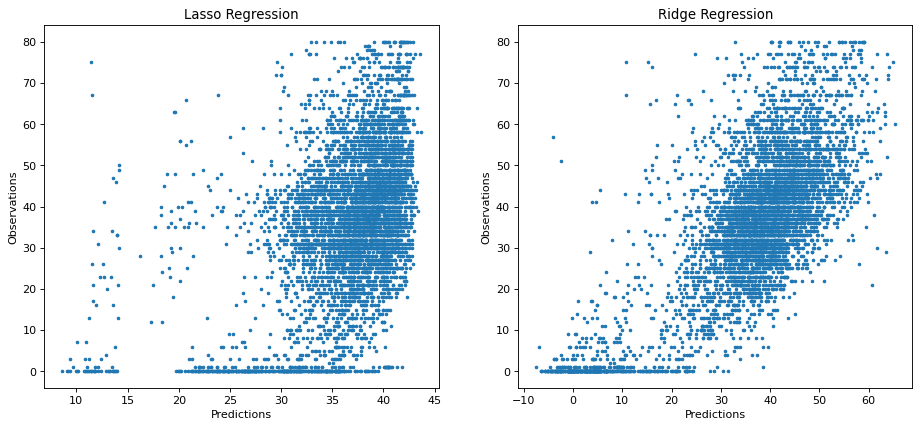

In [308]:
# Predictions vs Observations plots for validation
plt.figure(figsize=(14, 6), dpi=80)

plt.subplot(1, 2, 1)
plt.scatter(y_pred_val_lasso, y_val_scaled, s=5)
plt.xlabel("Predictions")
plt.ylabel("Observations")
plt.title("Lasso Regression")

plt.subplot(1, 2, 2)
plt.scatter(y_pred_val_ridge, y_val_scaled, s=5)
plt.xlabel("Predictions")
plt.ylabel("Observations")
plt.title("Ridge Regression")


Text(0.5, 1.0, 'Ridge Regression')

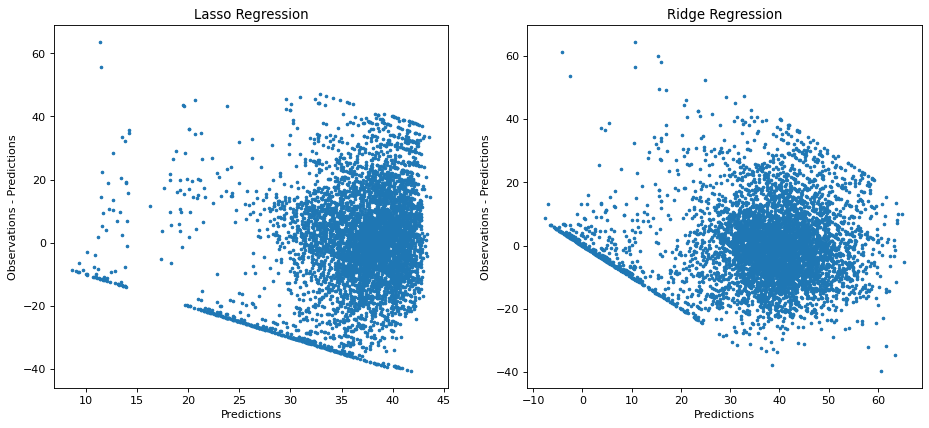

In [309]:
# Plot residuals for validation set

plt.figure(figsize=(14, 6), dpi=80)

plt.subplot(1, 2, 1)
plt.scatter(y_pred_val_lasso, y_val_scaled-y_pred_val_lasso, s=5)
plt.xlabel("Predictions")
plt.ylabel("Observations - Predictions")
plt.title("Lasso Regression")

plt.subplot(1, 2, 2)
plt.scatter(y_pred_val_ridge, y_val_scaled-y_pred_val_ridge, s=5)
plt.xlabel("Predictions")
plt.ylabel("Observations - Predictions")
plt.title("Ridge Regression")

In [310]:
import sklearn

print(f'R^2 for Linear on validation: {sklearn.metrics.r2_score(y_val, y_pred_val_linear)}')
print(f'R^2 for LASSO on validation: {sklearn.metrics.r2_score(y_val_scaled, y_pred_val_lasso)}')
print(f'R^2 for Ridge on validation: {sklearn.metrics.r2_score(y_val_scaled, y_pred_val_ridge)}')

R^2 for Linear on validation: 0.5273704767904235
R^2 for LASSO on validation: 0.17141297873049122
R^2 for Ridge on validation: 0.5277334295171643


### Hyper parameter tuning to improve predictions

#### data is already scaled above

In [311]:
from sklearn.model_selection import GridSearchCV
params = {'alpha': 10**np.linspace(-5, 4, 40)}

grid_search = GridSearchCV(Ridge(), params, cv = 4, scoring = "neg_root_mean_squared_error")
grid_search.fit(X_train_scaled, y_train_scaled)

GridSearchCV(cv=4, estimator=Ridge(),
             param_grid={'alpha': array([1.00000000e-05, 1.70125428e-05, 2.89426612e-05, 4.92388263e-05,
       8.37677640e-05, 1.42510267e-04, 2.42446202e-04, 4.12462638e-04,
       7.01703829e-04, 1.19377664e-03, 2.03091762e-03, 3.45510729e-03,
       5.87801607e-03, 1.00000000e-02, 1.70125428e-02, 2.89426612e-02,
       4.92388263e-02, 8.37677640e-02, 1.42510267e-01, 2....6202e-01,
       4.12462638e-01, 7.01703829e-01, 1.19377664e+00, 2.03091762e+00,
       3.45510729e+00, 5.87801607e+00, 1.00000000e+01, 1.70125428e+01,
       2.89426612e+01, 4.92388263e+01, 8.37677640e+01, 1.42510267e+02,
       2.42446202e+02, 4.12462638e+02, 7.01703829e+02, 1.19377664e+03,
       2.03091762e+03, 3.45510729e+03, 5.87801607e+03, 1.00000000e+04])},
             scoring='neg_root_mean_squared_error')

In [312]:
grid_search.cv_results_['mean_test_score']

array([-12.04731551, -12.04731548, -12.04731541, -12.04731531,
       -12.04731512, -12.04731481, -12.04731428, -12.04731337,
       -12.04731183, -12.04730922, -12.04730479, -12.04729729,
       -12.04728467, -12.04726357, -12.04722868, -12.04717216,
       -12.04708367, -12.04695278, -12.04677698, -12.04657702,
       -12.04641198, -12.04637023, -12.0465298 , -12.04696777,
       -12.0479565 , -12.05041629, -12.05667125, -12.07171976,
       -12.10536944, -12.17519867, -12.3086169 , -12.53914549,
       -12.89080784, -13.35401908, -13.87635917, -14.38827466,
       -14.8417953 , -15.22571761, -15.55560587, -15.8569998 ])

In [313]:
grid_search.best_score_

-12.046370231340134

In [314]:
grid_search.best_estimator_

Ridge(alpha=0.7017038286703837)

In [315]:
predicted_values_on_ridge_model_train = grid_search.best_estimator_.predict(X_train_scaled)
predicted_values_on_ridge_model_train

array([49.44310931, 52.92458309, 56.82690979, ..., 31.18307346,
       35.18423359, 44.4115523 ])

In [316]:
predicted_values_on_ridge_model_val = grid_search.best_estimator_.predict(X_val_scaled)
predicted_values_on_ridge_model_val

array([48.68705261, 43.64746272, 32.78837692, ..., -3.88117657,
       37.7270881 , 32.61897292])

In [317]:
print(f'Training MSE using optimized Ridge regression: {mean_squared_error(y_train_scaled, predicted_values_on_ridge_model_train)}')
print(f'Validation MSE using Ridge regression: {mean_squared_error(y_val_scaled, predicted_values_on_ridge_model_val)}')

Training MSE using optimized Ridge regression: 142.51272368522453
Validation MSE using Ridge regression: 144.34538692601464


Text(0.5, 1.0, 'Optimized Ridge Regression')

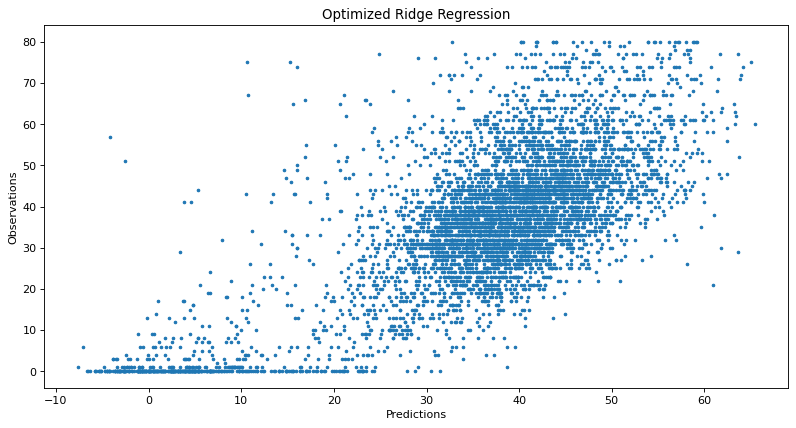

In [318]:
plt.figure(figsize=(12, 6), dpi=80)
plt.scatter(predicted_values_on_ridge_model_val, y_val_scaled, s=5)
plt.xlabel("Predictions")
plt.ylabel("Observations")
plt.title("Optimized Ridge Regression")

Text(0.5, 1.0, 'Optimized Ridge Regression Residuals')

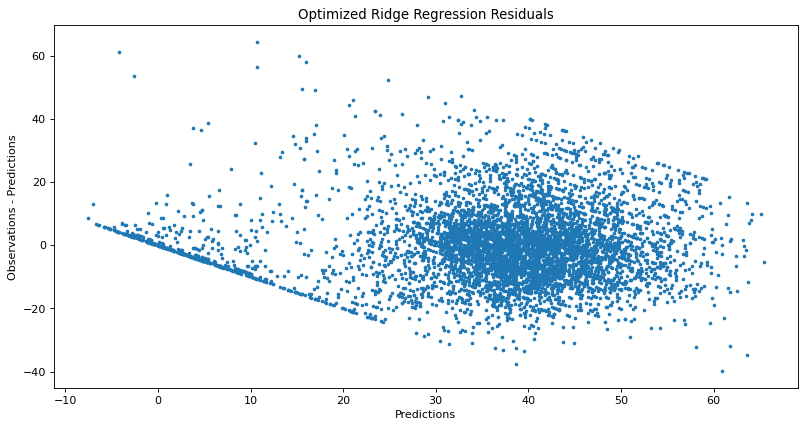

In [319]:
plt.figure(figsize=(12, 6), dpi=80)
plt.scatter(predicted_values_on_ridge_model_val, y_val_scaled-predicted_values_on_ridge_model_val, s=5)
plt.xlabel("Predictions")
plt.ylabel("Observations - Predictions")
plt.title("Optimized Ridge Regression Residuals")